In [80]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error

In [81]:
df = pd.read_csv('data/vehicles.csv')

In [82]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [84]:
df.describe

<bound method NDFrame.describe of                 id                  region  price    year manufacturer  \
0       7222695916                prescott   6000     NaN          NaN   
1       7218891961            fayetteville  11900     NaN          NaN   
2       7221797935            florida keys  21000     NaN          NaN   
3       7222270760  worcester / central MA   1500     NaN          NaN   
4       7210384030              greensboro   4900     NaN          NaN   
...            ...                     ...    ...     ...          ...   
426875  7301591192                 wyoming  23590  2019.0       nissan   
426876  7301591187                 wyoming  30590  2020.0        volvo   
426877  7301591147                 wyoming  34990  2020.0     cadillac   
426878  7301591140                 wyoming  28990  2018.0        lexus   
426879  7301591129                 wyoming  30590  2019.0          bmw   

                           model condition    cylinders    fuel  odometer  \


In [85]:
nof_model1 = df['model'].nunique()
print(nof_model1)

29649


In [86]:
## DROP the VIN column as it has no relation to price and will create a noise in the model
## Similarly DROP the model column as there are 29649 unique models in 426880 total number of rows (about 6.9% or on an average 14.4 rows per model
## It is reasonable to drop the model column as it can create noise in the related in the pricing models
## DROPPING VIN before dropping the rows with NaN values is important as VIN column has 265838 Non-null values out of total 426880 rowss
## This will ensure that rows with non-null values of other columns are not removed unnecessarily
df1 = df.drop(['VIN', 'model'], axis=1)

In [87]:
df_cl = df1.dropna()

In [88]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80170 entries, 31 to 426836
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            80170 non-null  int64  
 1   region        80170 non-null  object 
 2   price         80170 non-null  int64  
 3   year          80170 non-null  float64
 4   manufacturer  80170 non-null  object 
 5   condition     80170 non-null  object 
 6   cylinders     80170 non-null  object 
 7   fuel          80170 non-null  object 
 8   odometer      80170 non-null  float64
 9   title_status  80170 non-null  object 
 10  transmission  80170 non-null  object 
 11  drive         80170 non-null  object 
 12  size          80170 non-null  object 
 13  type          80170 non-null  object 
 14  paint_color   80170 non-null  object 
 15  state         80170 non-null  object 
dtypes: float64(2), int64(2), object(12)
memory usage: 10.4+ MB


In [89]:
''' After removing the VIN and model columns first and then removing rows with NaN values the number of rows available for analysis in the resulting dataframe 
df_cl is 80170. In the original dataframe df it was 426880 '''

' After removing the VIN and model columns first and then removing rows with NaN values the number of rows available for analysis in the resulting dataframe \ndf_cl is 80170. In the original dataframe df it was 426880 '

In [90]:
nof_region = df_cl['region'].nunique()
nof_manufacturer = df_cl['manufacturer'].nunique()
##nof_model = df_cl['model'].nunique()
nof_condition = df_cl['condition'].nunique()
nof_cylinders = df_cl['fuel'].nunique()
nof_fuel = df_cl['fuel'].nunique()
nof_title_status = df_cl['title_status'].nunique()
nof_transmission = df_cl['transmission'].nunique()
nof_drive = df_cl['drive'].nunique()
nof_type = df_cl['type'].nunique()
nof_paint_color = df_cl['paint_color'].nunique()
nof_state = df_cl['state'].nunique()

In [91]:
print('nof_region', nof_region)
print('nof_manufacturer', nof_manufacturer)
## print('nof_model', nof_model)
print('nof_condition', nof_condition)
print('nof_cylinders', nof_cylinders)
print('nof_fuel', nof_fuel)
print('nof_title_status', nof_title_status)
print('nof_transmission', nof_transmission)
print('nof_drive', nof_drive)
print('nof_type', nof_type)
print('nof_paint_color', nof_paint_color)
print('nof_state', nof_state)

nof_region 403
nof_manufacturer 41
nof_condition 6
nof_cylinders 5
nof_fuel 5
nof_title_status 6
nof_transmission 3
nof_drive 3
nof_type 13
nof_paint_color 12
nof_state 51


In [92]:
df_cl.set_index('id', inplace=True)

In [111]:
print(df_cl.head())
df_cl.info()

            region  price    year manufacturer  condition    cylinders  \
id                                                                       
7316356412  auburn  15000  2013.0         ford  excellent  6 cylinders   
7314560853  auburn  19900  2004.0         ford       good  8 cylinders   
7313406529  auburn  14000  2012.0        honda  excellent  6 cylinders   
7312847466  auburn  22500  2001.0         ford       good  8 cylinders   
7312144944  auburn  15000  2017.0        dodge  excellent  8 cylinders   

              fuel  odometer title_status transmission drive       size  \
id                                                                        
7316356412     gas  128000.0        clean    automatic   rwd  full-size   
7314560853  diesel   88000.0        clean    automatic   4wd  full-size   
7313406529     gas   95000.0        clean    automatic   fwd  full-size   
7312847466  diesel  144700.0        clean       manual   rwd  full-size   
7312144944     gas   90000.0   

In [ ]:
## Convert non-numeric columns to numeric columns

In [117]:
## Analyze cylinders column
## Check frequency of values
f_cylinders = df_cl['cylinders'].value_counts()
print(f_cylinders)

cylinders
6 cylinders     27370
4 cylinders     26256
8 cylinders     24556
10 cylinders      800
5 cylinders       727
other             256
3 cylinders       159
12 cylinders       46
Name: count, dtype: int64


In [131]:
## Count of 'other' can be safely dropped as it does not contain any numerical value
## first 1 or 2 characters of cylinders column contain the numerical value which can be stored in new column ncyl
df_cl1 = df_cl[df_cl['cylinders'] != 'other']


In [133]:
df_cl1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        79914 non-null  object 
 1   price         79914 non-null  int64  
 2   year          79914 non-null  float64
 3   manufacturer  79914 non-null  object 
 4   condition     79914 non-null  object 
 5   cylinders     79914 non-null  object 
 6   fuel          79914 non-null  object 
 7   odometer      79914 non-null  float64
 8   title_status  79914 non-null  object 
 9   transmission  79914 non-null  object 
 10  drive         79914 non-null  object 
 11  size          79914 non-null  object 
 12  type          79914 non-null  object 
 13  paint_color   79914 non-null  object 
 14  state         79914 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 9.8+ MB


In [141]:
df_cl1['ncyl'] = df_cl1['cylinders'].str.extract(r'(\d+)').astype(int)
df_cl1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        79914 non-null  object 
 1   price         79914 non-null  int64  
 2   year          79914 non-null  float64
 3   manufacturer  79914 non-null  object 
 4   condition     79914 non-null  object 
 5   cylinders     79914 non-null  object 
 6   fuel          79914 non-null  object 
 7   odometer      79914 non-null  float64
 8   title_status  79914 non-null  object 
 9   transmission  79914 non-null  object 
 10  drive         79914 non-null  object 
 11  size          79914 non-null  object 
 12  type          79914 non-null  object 
 13  paint_color   79914 non-null  object 
 14  state         79914 non-null  object 
 15  ncyl          79914 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(12)
memory usage: 10.1+ MB


In [149]:
df_cl2 = df_cl1.drop('cylinders', axis=1)
df_cl2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        79914 non-null  object 
 1   price         79914 non-null  int64  
 2   year          79914 non-null  float64
 3   manufacturer  79914 non-null  object 
 4   condition     79914 non-null  object 
 5   fuel          79914 non-null  object 
 6   odometer      79914 non-null  float64
 7   title_status  79914 non-null  object 
 8   transmission  79914 non-null  object 
 9   drive         79914 non-null  object 
 10  size          79914 non-null  object 
 11  type          79914 non-null  object 
 12  paint_color   79914 non-null  object 
 13  state         79914 non-null  object 
 14  ncyl          79914 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(11)
memory usage: 9.5+ MB


In [151]:
df_cl2.head()

,region,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,ncyl
id,,,,,,,,,,,,,,,
7316356412,auburn,15000,2013.0,ford,excellent,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,6
7314560853,auburn,19900,2004.0,ford,good,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al,8
7313406529,auburn,14000,2012.0,honda,excellent,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al,6
7312847466,auburn,22500,2001.0,ford,good,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al,8
7312144944,auburn,15000,2017.0,dodge,excellent,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al,8


In [153]:
## Analyze fuel column
## Check frequency of values
f_fuel = df_cl2['fuel'].value_counts()
print(f_fuel)

fuel
gas         73343
diesel       5476
hybrid        962
other          97
electric       36
Name: count, dtype: int64


In [155]:
## Analyze title_status column
## Check frequency of values
f_title_status = df_cl2['title_status'].value_counts()
print(f_title_status)

title_status
clean         75134
rebuilt        2719
salvage        1138
lien            688
missing         191
parts only       44
Name: count, dtype: int64


In [179]:
## drop title_status 'missing', 'parts only' 
## and 'salvage'
df_temp = df_cl2[df_cl2.title_status == 'parts only']

In [181]:
## Analyze transmission column
## Check frequency of values
f_transmission = df_cl2['transmission'].value_counts()
print(f_transmission)

transmission
automatic    73092
manual        5967
other          855
Name: count, dtype: int64


In [183]:
## Analyze drive column
## Check frequency of values
f_drive = df_cl2['drive'].value_counts()
print(f_drive)
## 4wd = '4 wheel drive', fwd = 'front wheel drive' and rwd = 'rear wheel drive'

drive
4wd    33737
fwd    28301
rwd    17876
Name: count, dtype: int64


In [185]:
## Analyze manufacturer column
## Check frequency of values
f_manufacturer = df_cl2['manufacturer'].value_counts()
print(f_manufacturer)

manufacturer
ford               15625
chevrolet          12226
toyota              7035
honda               4867
nissan              3969
jeep                3257
gmc                 3242
ram                 2977
dodge               2562
bmw                 2214
subaru              1983
mercedes-benz       1937
volkswagen          1761
hyundai             1756
kia                 1403
chrysler            1364
lexus               1241
cadillac            1233
buick               1056
mazda                978
audi                 936
pontiac              726
acura                726
lincoln              676
infiniti             654
volvo                615
mitsubishi           614
mini                 421
mercury              408
rover                390
saturn               340
porsche              269
jaguar               224
fiat                 125
harley-davidson       29
alfa-romeo            28
ferrari               16
datsun                14
land rover             8
aston-martin

In [187]:
## Analyze type column
## Check frequency of values
f_type = df_cl2['type'].value_counts()
print(f_type)

type
sedan          21927
SUV            20409
truck          13743
pickup          6729
coupe           4402
hatchback       3090
van             2807
convertible     2255
mini-van        1865
wagon           1702
other            496
offroad          349
bus              140
Name: count, dtype: int64


In [189]:
## Analyze type column
## Check paint_color of values
f_paint_color = df_cl2['paint_color'].value_counts()
print(f_paint_color)

paint_color
white     19534
black     14127
silver    11534
grey       9494
blue       8478
red        8076
green      2703
brown      2531
custom     2067
yellow      646
orange      473
purple      251
Name: count, dtype: int64


In [242]:
## create y series for price column
y = df_cl2['price']
print(type(y))

<class 'pandas.core.series.Series'>


In [221]:
## one hot encoding of manufacturer column
X_manuf = pd.get_dummies(df_cl2['manufacturer'])

## one hot encoding of condition column
X_condition = pd.get_dummies(df_cl2['condition'])

## one hot encoding of fuel column
X_fuel = pd.get_dummies(df_cl2['fuel'])

## one hot encoding of title_status column
X_title_status = pd.get_dummies(df_cl2['title_status'])

## one hot encoding of transmission column
X_transmission = pd.get_dummies(df_cl2['transmission'])

## one hot encoding of drive column
X_drive = pd.get_dummies(df_cl2['drive'])

## one hot encoding of type column
X_type = pd.get_dummies(df_cl2['type'])

In [236]:
## one hot encoding of paint_color column
X_paint_color = pd.get_dummies(df_cl2['paint_color'])

In [244]:
## Number of cyliders (ncyl)
X_ncyl = df_cl2[['ncyl']]
print(X_ncyl.info())
print(X_ncyl.head())
print(y)

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ncyl    79914 non-null  int32
dtypes: int32(1)
memory usage: 936.5 KB
None
            ncyl
id              
7316356412     6
7314560853     8
7313406529     6
7312847466     8
7312144944     8
id
7316356412    15000
7314560853    19900
7313406529    14000
7312847466    22500
7312144944    15000
              ...  
7302963673    18000
7302963273    18000
7302384818     9800
7302338378     6800
7302301268        0
Name: price, Length: 79914, dtype: int64


In [225]:
## Encode state column using frequency encoding
# Calculate the frequency of each state
frequency = df_cl2['state'].value_counts()

# Map the frequencies to the original column
df_cl2['f_state'] = df_cl2['state'].map(frequency)

df_cl2.head()
X_f_state = df_cl2[['f_state']]
print(type(X_f_state))

<class 'pandas.core.frame.DataFrame'>


In [246]:
## Re-construct the dataframe using individual feature dataframes with numeric columns (except the price column)

X = pd.concat([X_manuf, X_condition, X_ncyl, X_fuel, X_title_status, X_transmission, X_drive, X_type, X_paint_color, X_f_state], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 91 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   acura            79914 non-null  bool 
 1   alfa-romeo       79914 non-null  bool 
 2   aston-martin     79914 non-null  bool 
 3   audi             79914 non-null  bool 
 4   bmw              79914 non-null  bool 
 5   buick            79914 non-null  bool 
 6   cadillac         79914 non-null  bool 
 7   chevrolet        79914 non-null  bool 
 8   chrysler         79914 non-null  bool 
 9   datsun           79914 non-null  bool 
 10  dodge            79914 non-null  bool 
 11  ferrari          79914 non-null  bool 
 12  fiat             79914 non-null  bool 
 13  ford             79914 non-null  bool 
 14  gmc              79914 non-null  bool 
 15  harley-davidson  79914 non-null  bool 
 16  honda            79914 non-null  bool 
 17  hyundai          79914 non-null  bool 
 1

In [250]:
mod1_features = X.columns
type(mod1_features)

pandas.core.indexes.base.Index

In [254]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [256]:
## Build a simple regression model (#1)
veh_mod1 = LinearRegression(fit_intercept = False)
##mod1_feature = X.columns
veh_mod1.fit(X, y)

LinearRegression(fit_intercept=False)

In [260]:
## Print mod1 coefficients
print(veh_mod1.coef_)

[ 5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165839e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14  5.21165840e+14  5.21165840e+14  5.21165840e+14
  5.21165840e+14 -6.38563235e+13 -6.38563235e+13 -6.38563235e+13
 -6.38563235e+13 -6.38563235e+13 -6.38563235e+13  6.07755000e+04
 -7.66275881e+13 -7.66275882e+13 -7.66275882e+13 -7.66275884e+13
 -7.66275882e+13 -6.38563235e+13 -6.38563236e+13 -6.38563235e+13
 -6.38563235e+13 -6.38563235e+13 -6.38563236e+13 -1.27712647e+14
 -1.27712647e+14 -1.27712

In [264]:
veh_mod1_mse = mean_squared_error(veh_mod1.predict(X), y)
print(veh_mod1_mse)

190724289045623.47


In [266]:
## MSE is too high
## Analyzing the coefficients only two coefficients (cylinders = 6.07755000e+4 and f_state = 1.93750000e) are low. The rest of the features
## have very high coefficients
## As a result we DROP all the features with very high coeffcients and build veh_mod2
X2 = pd.concat([X_ncyl, X_f_state], axis=1)
X2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ncyl     79914 non-null  int32
 1   f_state  79914 non-null  int64
dtypes: int32(1), int64(1)
memory usage: 1.5 MB


In [268]:
## Build a simple regression model (#2)
veh_mod2 = LinearRegression(fit_intercept = False)
veh_mod2.fit(X2, y)

LinearRegression(fit_intercept=False)

In [274]:
## Print mod2 coefficients
print(veh_mod2.coef_)

[ 1.73724364e+04 -3.01661434e+00]


In [272]:
veh_mod2_mse = mean_squared_error(veh_mod2.predict(X2), y)
print(veh_mod2_mse)

190809685353575.2


In [292]:
## Model 3 - Add ncyl^2 column

df_cl2['ncyl_sq'] = df_cl2['ncyl'] ** 2
X_ncyl_sq = df_cl2['ncyl_sq']
X_ncyl_sq.info()
print(X_ncyl.head())
print(X_ncyl_sq.head())

<class 'pandas.core.series.Series'>
Index: 79914 entries, 7316356412 to 7302301268
Series name: ncyl_sq
Non-Null Count  Dtype
--------------  -----
79914 non-null  int32
dtypes: int32(1)
memory usage: 2.9 MB
            ncyl
id              
7316356412     6
7314560853     8
7313406529     6
7312847466     8
7312144944     8
id
7316356412    36
7314560853    64
7313406529    36
7312847466    64
7312144944    64
Name: ncyl_sq, dtype: int32


In [294]:
X3 = pd.concat([X2, X_ncyl_sq], axis=1)
X3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ncyl     79914 non-null  int32
 1   f_state  79914 non-null  int64
 2   ncyl_sq  79914 non-null  int32
dtypes: int32(2), int64(1)
memory usage: 3.8 MB


In [296]:
## Build a simple regression model (#3)
veh_mod3 = LinearRegression(fit_intercept = False)
veh_mod3.fit(X3, y)

LinearRegression(fit_intercept=False)

In [298]:
veh_mod3_mse = mean_squared_error(veh_mod3.predict(X3), y)
print(veh_mod3_mse)

190805791242070.0


In [300]:
## Build model 4 using PolynomialFeatures and Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
pipe_1 = Pipeline([
	('pipe1_transform', PolynomialFeatures(degree=3, include_bias = False)),
	('pipe1_regression', LinearRegression())
])
pipe_1.fit(X_ncyl[['ncyl']], y)

Pipeline(steps=[('pipe1_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('pipe1_regression', LinearRegression())])

In [302]:
## Compute mod4 (pipe_1) MSE
pipe_1_mse = mean_squared_error(pipe_1.predict(X_ncyl[['ncyl']]), y)
print(veh_mod3_mse)

190805791242070.0


In [304]:
## In each of the four models considered so far the training error is very large (we still have not performed any cross validation)
## Try onehotencoder and ordinalencoder in a pipeline

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector

##from sklearn import set_config

##set_config(display="diagram") #setting this will display your pipelines as seen above


In [336]:
## Build model #5
poly_ordinal_ohe = make_column_transformer((OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']), (OneHotEncoder(drop = 'if_binary'), ['transmission']), (OneHotEncoder(drop = 'if_binary'), ['drive']), (OneHotEncoder(drop = 'if_binary'), ['type']))
## , (PolynomialFeatures(include_bias = False, degree = 1), ['ncyl'])
pipe_5 = Pipeline([('transformer', poly_ordinal_ohe), 
                  ('linreg', LinearRegression())])

In [338]:
#X5 = pd.concat([X_condition, X_transmission, X_drive, X_type, X_ncyl], axis=1)
df_cl2.info()
pipe_5.fit(df_cl2[['condition', 'transmission', 'drive', 'type']], y)
## , 'ncyl'

<class 'pandas.core.frame.DataFrame'>
Index: 79914 entries, 7316356412 to 7302301268
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        79914 non-null  object 
 1   price         79914 non-null  int64  
 2   year          79914 non-null  float64
 3   manufacturer  79914 non-null  object 
 4   condition     79914 non-null  object 
 5   fuel          79914 non-null  object 
 6   odometer      79914 non-null  float64
 7   title_status  79914 non-null  object 
 8   transmission  79914 non-null  object 
 9   drive         79914 non-null  object 
 10  size          79914 non-null  object 
 11  type          79914 non-null  object 
 12  paint_color   79914 non-null  object 
 13  state         79914 non-null  object 
 14  ncyl          79914 non-null  int32  
 15  f_state       79914 non-null  int64  
 16  ncyl_sq       79914 non-null  int32  
dtypes: float64(2), int32(2), int64(2), object(11)
memory usage: 

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['transmission']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['drive']),
                                                 ('onehotencoder-3',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['type'])])),
                ('linreg', LinearRegression())])

In [340]:
mod5_preds = pipe_5.predict(df_cl2[['condition', 'transmission', 'drive', 'type', 'ncyl']])
mod5_mse = mean_squared_error(mod5_preds, y)
print(mod5_mse)

190769746997730.34


In [346]:
## Plot ncyl vs log(price)
## clean df_cl2 to remove price = 0 and create df_cl3

df_cl3 = df_cl2[df_cl2['price']!=0]
df_cl3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76446 entries, 7316356412 to 7302338378
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        76446 non-null  object 
 1   price         76446 non-null  int64  
 2   year          76446 non-null  float64
 3   manufacturer  76446 non-null  object 
 4   condition     76446 non-null  object 
 5   fuel          76446 non-null  object 
 6   odometer      76446 non-null  float64
 7   title_status  76446 non-null  object 
 8   transmission  76446 non-null  object 
 9   drive         76446 non-null  object 
 10  size          76446 non-null  object 
 11  type          76446 non-null  object 
 12  paint_color   76446 non-null  object 
 13  state         76446 non-null  object 
 14  ncyl          76446 non-null  int32  
 15  f_state       76446 non-null  int64  
 16  ncyl_sq       76446 non-null  int32  
dtypes: float64(2), int32(2), int64(2), object(11)
memory usage: 

In [350]:
import numpy as np
df_cl3['log_price'] = np.log(df_cl3['price'])

In [352]:
df_cl3.head()

,region,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,ncyl,f_state,ncyl_sq,log_price
id,,,,,,,,,,,,,,,,,,
7316356412,auburn,15000,2013.0,ford,excellent,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,6,876,36,9.615805
7314560853,auburn,19900,2004.0,ford,good,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al,8,876,64,9.898475
7313406529,auburn,14000,2012.0,honda,excellent,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al,6,876,36,9.546813
7312847466,auburn,22500,2001.0,ford,good,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al,8,876,64,10.021271
7312144944,auburn,15000,2017.0,dodge,excellent,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al,8,876,64,9.615805


<Axes: xlabel='ncyl', ylabel='log_price'>

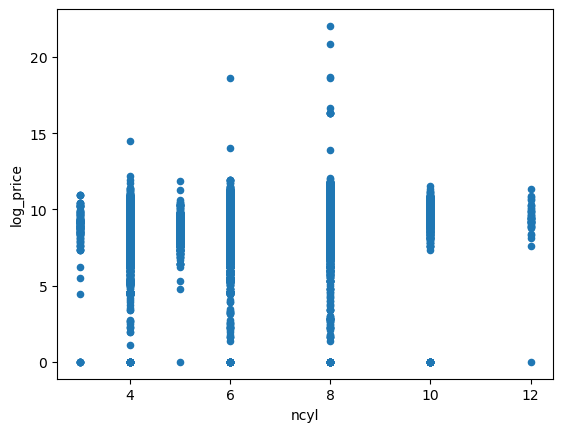

In [366]:
df_cl3.plot(x='ncyl', y='log_price', kind='scatter')

In [374]:
## Model 6 -- ncyl and log_price

veh_mod6 = LinearRegression(fit_intercept = False)
y_df3 = df_cl3['log_price']
veh_mod6.fit(df_cl3[['ncyl']], y_df3)

LinearRegression(fit_intercept=False)

In [380]:
mod6_mse = mean_squared_error(veh_mod6.predict(df_cl3[['ncyl']]), y_df3)
print(mod6_mse)

6.8816110644533195


In [388]:
## model # 7 using log_price and a pipeline

poly_ordinal_ohe7 = make_column_transformer((OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']), (OneHotEncoder(drop = 'if_binary'), ['transmission']), (OneHotEncoder(drop = 'if_binary'), ['drive']), (OneHotEncoder(drop = 'if_binary'), ['type']), (PolynomialFeatures(include_bias = False, degree = 3), ['ncyl']))
pipe_7 = Pipeline([('transformer', poly_ordinal_ohe7), 
                  ('linreg', LinearRegression())])
pipe_7.fit(df_cl3[['condition', 'transmission', 'drive', 'type', 'ncyl']], y_df3)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['transmission']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['drive']),
                                                 ('onehotencoder-3',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['type']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['ncyl'])])),
                ('linreg', LinearRegression())])

In [390]:
## Model #7 MSE

mod7_preds = pipe_7.predict(df_cl3[['condition', 'transmission', 'drive', 'type', 'ncyl']])
mod7_mse = mean_squared_error(mod7_preds, y_df3)

In [392]:
print(mod7_mse)

1.3119076332608168


In [394]:
## Create4 model #8 with all features (except region as in model #1) with log_price as the target variable
## Use df_cl3 since it has no rows with zero price
df_cl3.info()
## Use all features except region
## One hot encoder for manufacturer, fuel, title_status, transmission, drive, size, type, paint_color
## Ordinal encoder for condition
## frequency encoder for state which has been encoded in the f_state column
## numeric features ncyl (degree=3), year, odometer

<class 'pandas.core.frame.DataFrame'>
Index: 76446 entries, 7316356412 to 7302338378
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        76446 non-null  object 
 1   price         76446 non-null  int64  
 2   year          76446 non-null  float64
 3   manufacturer  76446 non-null  object 
 4   condition     76446 non-null  object 
 5   fuel          76446 non-null  object 
 6   odometer      76446 non-null  float64
 7   title_status  76446 non-null  object 
 8   transmission  76446 non-null  object 
 9   drive         76446 non-null  object 
 10  size          76446 non-null  object 
 11  type          76446 non-null  object 
 12  paint_color   76446 non-null  object 
 13  state         76446 non-null  object 
 14  ncyl          76446 non-null  int32  
 15  f_state       76446 non-null  int64  
 16  ncyl_sq       76446 non-null  int32  
 17  log_price     76446 non-null  float64
dtypes: float64(3), in

In [396]:
## Model #8

## model # 8 using log_price and a pipeline

poly_ordinal_ohe8 = make_column_transformer((OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']), (OneHotEncoder(drop = 'if_binary'), ['transmission']), (OneHotEncoder(drop = 'if_binary'), ['drive']), (OneHotEncoder(drop = 'if_binary'), ['type']), (OneHotEncoder(drop = 'if_binary'), ['manufacturer']), (OneHotEncoder(drop = 'if_binary'), ['fuel']), (OneHotEncoder(drop = 'if_binary'), ['title_status']), (OneHotEncoder(drop = 'if_binary'), ['size']), (OneHotEncoder(drop = 'if_binary'), ['paint_color']),(PolynomialFeatures(include_bias = False, degree = 3), ['ncyl']), (PolynomialFeatures(include_bias = False, degree = 1), ['year']), (PolynomialFeatures(include_bias = False, degree = 1), ['odometer']), (PolynomialFeatures(include_bias = False, degree = 1), ['f_state']))
pipe_8 = Pipeline([('transformer', poly_ordinal_ohe8), 
                  ('linreg', LinearRegression())])

feature_list8 = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'condition', 'f_state', 'ncyl' , 'year', 'odometer']
pipe_8.fit(df_cl3[feature_list8], y_df3)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['transmission']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['drive']),
                                                 ('onehotencoder-3',
                                                  OneHotEncoder(drop=...
                                                 ('polynomialfeatures-1',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['ncyl']),
                                                 ('polynomialfeatures-2',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['year']),
                                                 ('polynomialfeatures-3',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['odometer']),
                                                 ('polynomialfeatures-4',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['f_state'])])),
                ('linreg', LinearRegression())])

In [404]:
## Model #8 MSE

mod8_preds = pipe_8.predict(df_cl3[feature_list8])
mod8_mse = mean_squared_error(mod8_preds, y_df3)
print(mod8_mse)

1.6665850575448429


In [440]:
### Model #8 training error (with whole dataframe as training set) is higher than model #7, which uses less number of features
### Analyzing coefficients for model #8
coef_8 = pipe_8.named_steps['linreg'].coef_
output_features_8 = pipe_8[:-1].get_feature_names_out()
feat_coef_8 = np.column_stack((output_features_8, coef_8))
print(feat_coef_8)

[['ordinalencoder__condition' 0.03825406795402904]
 ['onehotencoder-1__transmission_automatic' 0.009228142467611508]
 ['onehotencoder-1__transmission_manual' 0.0018851195279963881]
 ['onehotencoder-1__transmission_other' -0.011113261995608402]
 ['onehotencoder-2__drive_4wd' 0.009847142850291219]
 ['onehotencoder-2__drive_fwd' -0.018359247705070764]
 ['onehotencoder-2__drive_rwd' 0.008512104854780001]
 ['onehotencoder-3__type_SUV' 0.0014531474553090215]
 ['onehotencoder-3__type_bus' -0.00014635241818272758]
 ['onehotencoder-3__type_convertible' 0.002508021274119308]
 ['onehotencoder-3__type_coupe' 0.0005330327028758139]
 ['onehotencoder-3__type_hatchback' -0.0013274957067129064]
 ['onehotencoder-3__type_mini-van' -0.0016306487414280912]
 ['onehotencoder-3__type_offroad' 0.0004769689978282594]
 ['onehotencoder-3__type_other' -2.458697687174545e-05]
 ['onehotencoder-3__type_pickup' 0.005673837200090431]
 ['onehotencoder-3__type_sedan' -0.020206585323387594]
 ['onehotencoder-3__type_truck'

In [456]:
## Analyze Model #8 coefficients and statistics
## Import stats package
from scipy import stats

# Calculate standard errors
predictions = pipe_8.predict(df_cl3)
residuals = y_df3 - predictions

## rss = Residual sum of squares
rss = np.sum(residuals**2)
degrees_of_freedom = len(y_df3) - len(coef_8) - 1

## s2 is Estimated Variance of the Residuals
s2 = rss / degrees_of_freedom

mod8_transformed_data = pipe_8.named_steps['transformer'].transform(df_cl3)

X_design = np.hstack([np.ones((df_cl3.shape[0], 1)), mod8_transformed_data.toarray()])
cov_matrix = s2 * np.linalg.inv(X_design.T @ X_design)
standard_errors = np.sqrt(np.diag(cov_matrix))

# Calculate t-statistics and p-values
t_stats = coef_8 / standard_errors[1:]  # Exclude intercept
p_values = [2 * (1 - stats.t.cdf(np.abs(t), degrees_of_freedom)) for t in t_stats]

# Combine feature names, coefficients, standard errors, t-statistics, and p-values
results = pd.DataFrame({
    'Feature': output_features_8,
    'Coefficient': coef_8,
    'Standard Error': standard_errors[1:],  # Exclude intercept
    't-Statistic': t_stats,
    'p-Value': p_values
})

print(results)

                                    Feature   Coefficient  Standard Error  \
0                 ordinalencoder__condition  3.825407e-02    6.402166e-03   
1   onehotencoder-1__transmission_automatic  9.228142e-03             NaN   
2      onehotencoder-1__transmission_manual  1.885120e-03             NaN   
3       onehotencoder-1__transmission_other -1.111326e-02             NaN   
4                onehotencoder-2__drive_4wd  9.847143e-03             NaN   
..                                      ...           ...             ...   
89             polynomialfeatures-1__ncyl^2  8.762569e-02    1.861288e-02   
90             polynomialfeatures-1__ncyl^3 -8.125750e-03    9.388282e-04   
91               polynomialfeatures-2__year  2.172440e-02    5.587384e-04   
92           polynomialfeatures-3__odometer -4.858785e-07    2.319372e-08   
93            polynomialfeatures-4__f_state -4.441434e-05    1.982290e-06   

    t-Statistic       p-Value  
0      5.975176  2.308564e-09  
1          

In [470]:
# Select the rows with the highest 10 values
highest_7_tstat = results.nlargest(7, 't-Statistic')

# Select the rows with the lowest 10 values
lowest_7_pval = results.nsmallest(7, 'p-Value')

In [472]:
print(highest_7_tstat)

                           Feature   Coefficient  Standard Error  t-Statistic  \
91      polynomialfeatures-2__year  2.172440e-02    5.587384e-04    38.881176   
0        ordinalencoder__condition  3.825407e-02    6.402166e-03     5.975176   
89    polynomialfeatures-1__ncyl^2  8.762569e-02    1.861288e-02     4.707799   
88      polynomialfeatures-1__ncyl  1.235080e-02    1.187531e-01     0.104004   
90    polynomialfeatures-1__ncyl^3 -8.125750e-03    9.388282e-04    -8.655205   
92  polynomialfeatures-3__odometer -4.858785e-07    2.319372e-08   -20.948704   
93   polynomialfeatures-4__f_state -4.441434e-05    1.982290e-06   -22.405576   

         p-Value  
91  0.000000e+00  
0   2.308564e-09  
89  2.508449e-06  
88  9.171664e-01  
90  0.000000e+00  
92  0.000000e+00  
93  0.000000e+00  


In [474]:
print(lowest_7_pval)

                           Feature   Coefficient  Standard Error  t-Statistic  \
90    polynomialfeatures-1__ncyl^3 -8.125750e-03    9.388282e-04    -8.655205   
91      polynomialfeatures-2__year  2.172440e-02    5.587384e-04    38.881176   
92  polynomialfeatures-3__odometer -4.858785e-07    2.319372e-08   -20.948704   
93   polynomialfeatures-4__f_state -4.441434e-05    1.982290e-06   -22.405576   
0        ordinalencoder__condition  3.825407e-02    6.402166e-03     5.975176   
89    polynomialfeatures-1__ncyl^2  8.762569e-02    1.861288e-02     4.707799   
88      polynomialfeatures-1__ncyl  1.235080e-02    1.187531e-01     0.104004   

         p-Value  
90  0.000000e+00  
91  0.000000e+00  
92  0.000000e+00  
93  0.000000e+00  
0   2.308564e-09  
89  2.508449e-06  
88  9.171664e-01  


In [ ]:
## Observation
## Both t-Statistic and p-Values have the same set of features in the 7 most significant t-Statistic and p-Value sets
## p-Value of ncyl feature is > 0.05
## Accrdingly the six fetaures viz. ncyl^3, year, odometer, f_state, condition and ncyl^2 have p-values < 0.05 and are most significant

In [490]:
results['abs_t-Statistic'] = results['t-Statistic'].abs()

# Select the rows with the 10 largest tstat absolute values
largest_7_abs_tstat = results.nlargest(7, 'abs_t-Statistic')
print(largest_7_abs_tstat)

                           Feature   Coefficient  Standard Error  t-Statistic  \
91      polynomialfeatures-2__year  2.172440e-02    5.587384e-04    38.881176   
93   polynomialfeatures-4__f_state -4.441434e-05    1.982290e-06   -22.405576   
92  polynomialfeatures-3__odometer -4.858785e-07    2.319372e-08   -20.948704   
90    polynomialfeatures-1__ncyl^3 -8.125750e-03    9.388282e-04    -8.655205   
0        ordinalencoder__condition  3.825407e-02    6.402166e-03     5.975176   
89    polynomialfeatures-1__ncyl^2  8.762569e-02    1.861288e-02     4.707799   
88      polynomialfeatures-1__ncyl  1.235080e-02    1.187531e-01     0.104004   

         p-Value  abs_t-Statistic  
91  0.000000e+00        38.881176  
93  0.000000e+00        22.405576  
92  0.000000e+00        20.948704  
90  0.000000e+00         8.655205  
0   2.308564e-09         5.975176  
89  2.508449e-06         4.707799  
88  9.171664e-01         0.104004  


In [558]:
## Both the +ve and -ve values of t-stat are importtant, the top 7 abs values of t-stat yield the same 7 features as before and same as for p-values

In [494]:
## Model 8 MSE
print(s2) ## calculated above

1.668658711858038


In [518]:
### Sequential feature Selection -- Use mod8_transformed_data as the starting point
### convert mod8_transformed_data to ndarray mod8_arr

mod8_arr = mod8_transformed_data.toarray()

### Convert mod8_arr to DataFrame

mod8_df = pd.DataFrame(mod8_arr)

mod8_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76446 entries, 0 to 76445
Data columns (total 94 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       76446 non-null  float64
 1   1       76446 non-null  float64
 2   2       76446 non-null  float64
 3   3       76446 non-null  float64
 4   4       76446 non-null  float64
 5   5       76446 non-null  float64
 6   6       76446 non-null  float64
 7   7       76446 non-null  float64
 8   8       76446 non-null  float64
 9   9       76446 non-null  float64
 10  10      76446 non-null  float64
 11  11      76446 non-null  float64
 12  12      76446 non-null  float64
 13  13      76446 non-null  float64
 14  14      76446 non-null  float64
 15  15      76446 non-null  float64
 16  16      76446 non-null  float64
 17  17      76446 non-null  float64
 18  18      76446 non-null  float64
 19  19      76446 non-null  float64
 20  20      76446 non-null  float64
 21  21      76446 non-null  float64
 22

In [536]:
### mod8_df and the target y_df3 that contains log_price have different index values as mod8_df is the output of pipe_8
### Copy y_df3 to y_df4 and set y_df4 index same as mod8_df 
y_df4 = y_df3
y_df4.index = mod8_df.index

## use y_df4 in Sequential feature selection

In [524]:
### Sequential feature Selection -- Use df_cl3

from random import shuffle, seed

all_ind = mod8_df.index.to_numpy()
seed(42)
shuffle(all_ind)

all_ind[:5] 

array([35937,  4964, 59654,  6989, 20987], dtype=int64)

In [526]:
## Split all_ind into train and test sets (80% of 76446 = 61157 training records and 20% or 15289 test or validation records)

train_idx, test_idx = np.split(all_ind, [61157])

## Split y_df3 into train and test indices

print(train_idx[:5])
print(test_idx[:5])

[35937  4964 59654  6989 20987]
[13343 46794  4781 20991 46688]


In [544]:
## We will try the no of features to select as 7
## Dataframe mod8_df is equal to the output of the 'transformer' step in pipe_8 pipeline
##

from sklearn.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LinearRegression(), scoring='neg_mean_squared_error',cv=[[train_idx, test_idx]], n_features_to_select=7)

Xt = selector.fit_transform(mod8_df, y_df4)


In [548]:
Xt_df = pd.DataFrame(Xt)
print(Xt_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76446 entries, 0 to 76445
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       76446 non-null  float64
 1   1       76446 non-null  float64
 2   2       76446 non-null  float64
 3   3       76446 non-null  float64
 4   4       76446 non-null  float64
 5   5       76446 non-null  float64
 6   6       76446 non-null  float64
dtypes: float64(7)
memory usage: 4.1 MB
None


In [564]:
lr9 = LinearRegression().fit(Xt_df, y_df4)
model_preds9 = lr.predict(Xt)
mse9 = mean_squared_error(y_df4, model_preds9)

print(mse9)

1.3144517741100517


In [556]:
### the sequential feature selection gives the MSE as 1.3144517741100517 using 7 most significant features 
### comparted to the MSE of 1.668658711858038 in model #8 with 94 features

(76446, 7)


In [640]:
df_cl4 = df_cl3
df_cl4.index = mod8_df.index

In [668]:
### Model #10 RIDGE model with GridSearchCV
### We use the same set of transformers that were used for model #8 = poly_ordinal_ohe8
### We use the same train_idx and test_idx indices that were used in model #8

##from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaled_ridge_model = Pipeline([
	('transformer', poly_ordinal_ohe8),
	('scale', StandardScaler(with_mean=False)),
    ('regression', Ridge())
])

feature_list9 = ['condition', 'transmission', 'drive', 'type', 'paint_color', 'ncyl', 'year', 'odometer', 'f_state']
parameters_to_try = {'regression__alpha': 10**np.linspace(-5, 4, 100)}

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
model_finder = GridSearchCV(estimator = scaled_ridge_model,
		param_grid = parameters_to_try,
		scoring = "neg_mean_squared_error",
		cv = [[train_idx, test_idx]])
model_finder.fit(df_cl4, y_df4)
### [['condition', 'transmission', 'drive', 'type', 'paint_color', 'ncyl', 'year', 'odometer', 'f_state']]
best_model = model_finder.best_estimator_
best_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['transmission']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['drive']),
                                                 ('onehotencoder-3',
                                                  OneHotEncoder(drop=...
                                                                     include_bias=False),
                                                  ['ncyl']),
                                                 ('polynomialfeatures-2',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['year']),
                                                 ('polynomialfeatures-3',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['odometer']),
                                                 ('polynomialfeatures-4',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['f_state'])])),
                ('scale', StandardScaler(with_mean=False)),
                ('regression', Ridge(alpha=1e-05))])

In [672]:
best_model.named_steps['regression'].coef_

parameters_to_try = {'regression__alpha': [0.001, 1, 1000]}
model_finder.cv_results_

{'mean_fit_time': array([0.40513039, 0.3578825 , 0.34296012, 0.34601474, 0.3921454 ,
        0.37634015, 0.36511254, 0.37957692, 0.36839509, 0.58620763,
        0.41693234, 0.38350773, 0.37325978, 0.37136507, 0.37616968,
        0.38006258, 0.37160921, 0.38297176, 0.38767123, 0.37230444,
        0.37499022, 0.35425186, 0.37560773, 0.37651968, 0.3648634 ,
        0.38059831, 0.3704071 , 0.35181618, 0.37156868, 0.37387133,
        0.36473274, 0.36780715, 0.34947443, 0.36116958, 0.34406996,
        0.33521199, 0.3692832 , 0.33931756, 0.37404203, 0.38010645,
        0.36152983, 0.37234139, 0.35251927, 0.37390232, 0.36464763,
        0.38292527, 0.36208701, 0.34106088, 0.36125398, 0.36526084,
        0.37832284, 0.36777973, 0.35561609, 0.36393356, 0.38162541,
        0.36694145, 0.37464738, 0.34283924, 0.36665416, 0.36637688,
        0.36862803, 0.37617016, 0.36412764, 0.37411237, 0.3718276 ,
        0.37029576, 0.35961032, 0.38018894, 0.36321354, 0.36761928,
        0.3465457 , 0.33294296,

In [685]:
### retrieve best alpha

best_alpha = model_finder.best_params_['regression__alpha']
print("Best alpha:", best_alpha)

Best alpha: 1e-05


In [687]:
## Compute test set MSE for best_alpha

X_test = df_cl4.iloc[test_idx]
y_test = y_df4.iloc[test_idx]

y_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
print(test_mse)

1.191933129669491


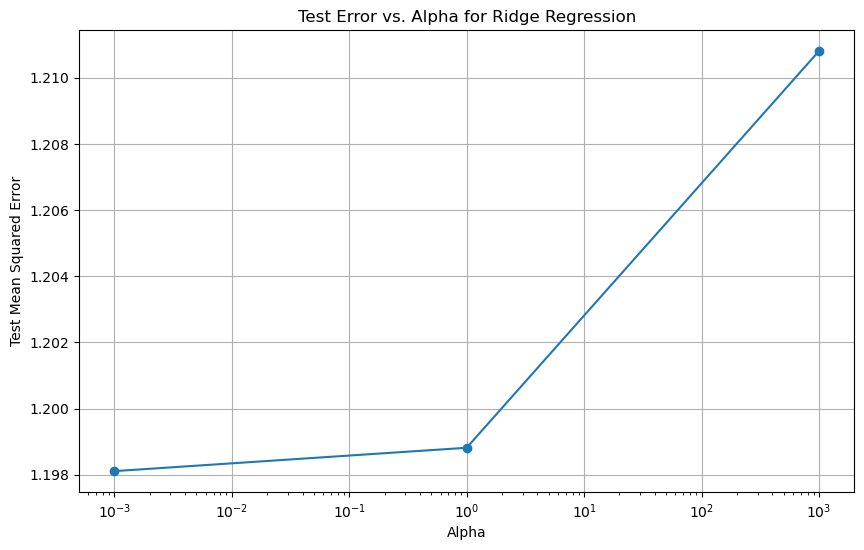

In [689]:
### Plot test error vs alpha

alphas = parameters_to_try['regression__alpha']
test_errors = []

X_test = df_cl4.iloc[test_idx]
y_test = y_df4.iloc[test_idx]

# Loop through alpha values
for alpha in alphas:
    model = Ridge(alpha=alpha)
    pipeline = Pipeline(steps=[
        ('transformer', poly_ordinal_ohe8),
        ('scale', StandardScaler(with_mean=False)),
        ('regression', model)
    ])
    pipeline.fit(df_cl4.iloc[train_idx], y_df4.iloc[train_idx])
    y_pred = pipeline.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_errors.append(test_mse)

# Plot the test error versus alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, test_errors, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Test Mean Squared Error')
plt.title('Test Error vs. Alpha for Ridge Regression')
plt.grid(True)
plt.show()

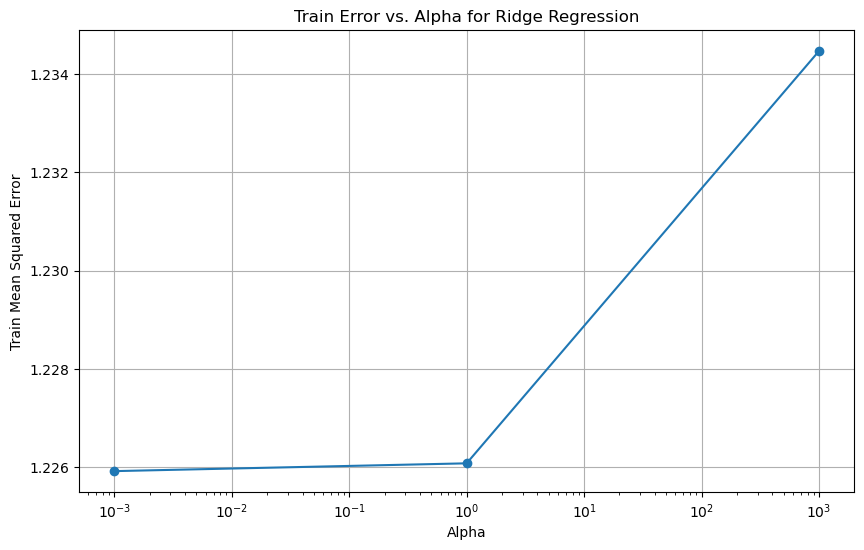

In [691]:
### Plot train error vs alpha

alphas = parameters_to_try['regression__alpha']
train_errors = []

X_train = df_cl4.iloc[train_idx]
y_train = y_df4.iloc[train_idx]

# Loop through alpha values
for alpha in alphas:
    model = Ridge(alpha=alpha)
    pipeline = Pipeline(steps=[
        ('transformer', poly_ordinal_ohe8),
        ('scale', StandardScaler(with_mean=False)),
        ('regression', model)
    ])
    pipeline.fit(df_cl4.iloc[train_idx], y_df4.iloc[train_idx])
    y_pred_train = pipeline.predict(X_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_errors.append(train_mse)

# Plot the train error versus alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Train Mean Squared Error')
plt.title('Train Error vs. Alpha for Ridge Regression')
plt.grid(True)
plt.show()

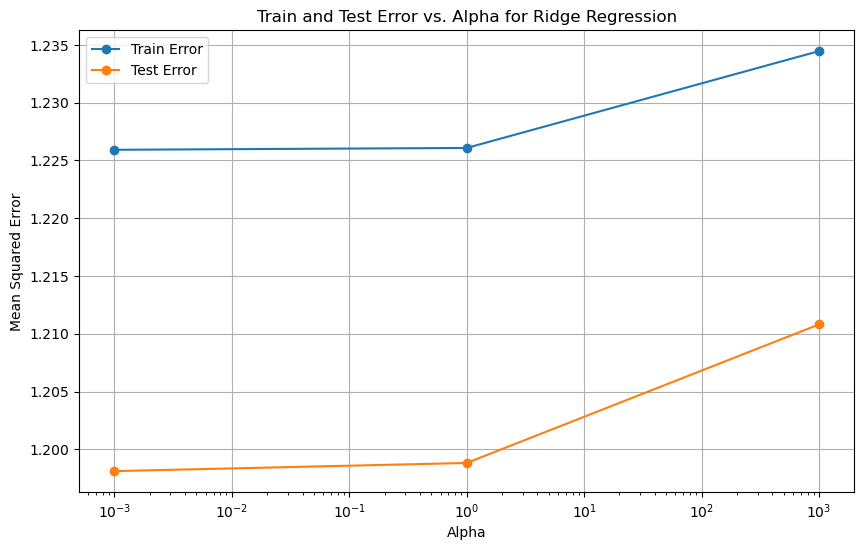

In [697]:
## Superimpose both train and test error charts

plt.figure(figsize=(10, 6))
plt.plot(parameters_to_try['regression__alpha'], train_errors, label='Train Error', marker='o')
plt.plot(parameters_to_try['regression__alpha'], test_errors, label='Test Error', marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Train and Test Error vs. Alpha for Ridge Regression')
plt.legend()
plt.grid(True)
plt.show()

In [699]:
print(df_cl4.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76446 entries, 0 to 76445
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        76446 non-null  object 
 1   price         76446 non-null  int64  
 2   year          76446 non-null  float64
 3   manufacturer  76446 non-null  object 
 4   condition     76446 non-null  object 
 5   fuel          76446 non-null  object 
 6   odometer      76446 non-null  float64
 7   title_status  76446 non-null  object 
 8   transmission  76446 non-null  object 
 9   drive         76446 non-null  object 
 10  size          76446 non-null  object 
 11  type          76446 non-null  object 
 12  paint_color   76446 non-null  object 
 13  state         76446 non-null  object 
 14  ncyl          76446 non-null  int32  
 15  f_state       76446 non-null  int64  
 16  ncyl_sq       76446 non-null  int32  
 17  log_price     76446 non-null  float64
dtypes: float64(3), int32(2), i